In [1]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [ ]:
torch.use_deterministic_algorithms(True)

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
dataroot = "/content/drive/MyDrive/Brock University/8th Semester/COSC 4P80/4P80 Project/data/forgeryNetSample"

In [21]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(128),
                               transforms.CenterCrop(128),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])) # transforming images and converting to tensors

In [22]:
print(f"Number of images in dataset: {len(dataset)}")

Number of images in dataset: 1000


In [23]:
dataset[0][0]

tensor([[[ 0.9608,  0.9686,  0.9686,  ...,  0.9765,  0.9765,  0.9765],
         [ 0.9686,  0.9686,  0.9608,  ...,  0.9765,  0.9765,  0.9765],
         [ 0.9686,  0.9686,  0.9608,  ...,  0.9765,  0.9765,  0.9765],
         ...,
         [ 0.8980,  0.6314,  0.2078,  ...,  1.0000,  1.0000,  1.0000],
         [-0.0510, -0.5216, -0.7098,  ...,  0.6549,  0.8980,  0.9765],
         [-0.6706, -0.7176, -0.7647,  ..., -0.4902, -0.0353,  0.5059]],

        [[ 0.9686,  0.9765,  0.9765,  ...,  0.9843,  0.9922,  0.9922],
         [ 0.9765,  0.9765,  0.9686,  ...,  0.9843,  0.9922,  0.9922],
         [ 0.9765,  0.9765,  0.9686,  ...,  0.9843,  0.9922,  0.9922],
         ...,
         [ 0.8980,  0.6392,  0.2078,  ...,  1.0000,  1.0000,  1.0000],
         [-0.0510, -0.5059, -0.7098,  ...,  0.6549,  0.8980,  0.9765],
         [-0.6706, -0.7020, -0.7647,  ..., -0.4902, -0.0431,  0.5059]],

        [[ 0.9843,  0.9922,  0.9922,  ...,  1.0000,  0.9843,  0.9843],
         [ 0.9922,  0.9922,  0.9843,  ...,  1

In [24]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2) # loading dataset with dataloader.

In [25]:
print(f"Number of batches in dataloader: {len(dataloader)}")

Number of batches in dataloader: 63


In [26]:
# Decides device type to run on
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)

cuda:0


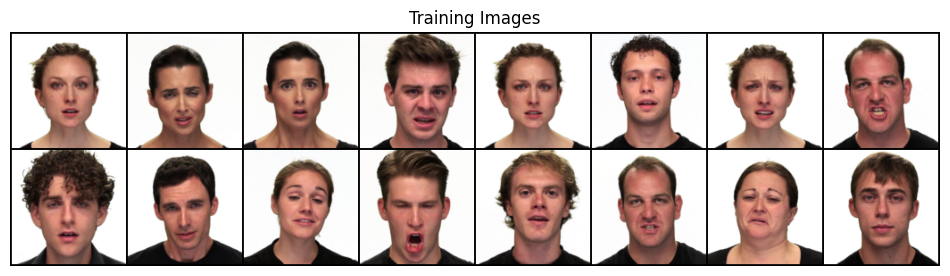

In [27]:
# loads 64 training images.
real_batch = next(iter(dataloader))
plt.figure(figsize=(12,12))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:16], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [28]:
class generatorNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.c0 = nn.ConvTranspose2d(100, 512, 4, 1, 0, bias = False)
    self.c1 = nn.ConvTranspose2d(512, 256, 4, 2, 1, bias = False)
    self.c2 = nn.ConvTranspose2d(256, 128, 4, 2, 1, bias = False)
    self.c3 = nn.ConvTranspose2d(128, 64, 4, 2, 1, bias = False)
    self.c4 = nn.ConvTranspose2d(64, 32, 4, 2, 1, bias = False)
    self.c5 = nn.ConvTranspose2d(32, 3, 4, 2, 1, bias = False)

    # batch normalization
    self.bn0 = nn.BatchNorm2d(512)
    self.bn1 = nn.BatchNorm2d(256)
    self.bn2 = nn.BatchNorm2d(128)
    self.bn3 = nn.BatchNorm2d(64)
    self.bn4 = nn.BatchNorm2d(32)

  # Forward Propagation
  def forward(self, x):
    x = F.relu(self.bn0(self.c0(x)))
    x = F.relu(self.bn1(self.c1(x)))
    x = F.relu(self.bn2(self.c2(x)))
    x = F.relu(self.bn3(self.c3(x)))
    x = F.relu(self.bn4(self.c4(x)))

    return torch.tanh(self.c5(x))

In [30]:
class discriminatorNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.c1 = nn.Conv2d(3, 32, 4, 2, 1, bias = False)
    self.c2 = nn.Conv2d(32, 64, 4, 2, 1, bias = False)
    self.c3 = nn.Conv2d(64, 128, 4, 2, 1, bias = False)
    self.c4 = nn.Conv2d(128, 256, 4, 2, 1, bias = False)
    self.c5 = nn.Conv2d(256, 512, 4, 2, 1, bias = False)
    self.c6 = nn.Conv2d(512, 1, 4, 1, 0, bias = False)

    # batch Normalization
    self.bn2 = nn.BatchNorm2d(64)
    self.bn3 = nn.BatchNorm2d(128)
    self.bn4 = nn.BatchNorm2d(256)
    self.bn5 = nn.BatchNorm2d(512)

  # Forward Propagation
  def forward(self, x):
    x = F.leaky_relu(self.c1(x), 0.2, inplace = True)

    x = F.leaky_relu(self.c2(x), 0.2, inplace = True)
    x = self.bn2(x)

    x = F.leaky_relu(self.c3(x), 0.2, inplace = True)
    x = self.bn3(x)

    x = F.leaky_relu(self.c4(x), 0.2, inplace = True)
    x = self.bn4(x)

    x = F.leaky_relu(self.c5(x), 0.2, inplace = True)
    x = self.bn5(x)

    return torch.sigmoid(self.c6(x)).view(-1,1)

In [31]:
lossFunc = nn.BCELoss() # Binary Cross Entropy Loss function

# label definition
real_label = 1
fake_label = 0

# initializing the models
dNet = discriminatorNet().to(device)
gNet = generatorNet().to(device)

print(dNet)
print(gNet)

# initializing optimizers for both models
dOpt = optim.Adam(dNet.parameters(), lr = 0.0002, betas = (0.5, 0.999))
gOpt = optim.Adam(gNet.parameters(), lr = 0.0002, betas = (0.5, 0.999))

discriminatorNet(
  (c1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (c2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (c3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (c4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (c5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (c6): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
generatorNet(
  (c0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (c1): ConvTranspose2

In [32]:
num_epochs = 100
losses_G = []
losses_D = []
disDecs = []
iters = 0
img_list = []

for epoch in range(num_epochs):
  # torch.autograd.set_detect_anomaly(True)
  for i, data in enumerate(dataloader, 0):

    dNet.zero_grad()
    # Training with Real Data
    # Training Discriminator Network

    dataSegment = data[0].to(device)
    batchSize = dataSegment.size(0)

    label = torch.full((batchSize,), real_label, dtype=torch.float, device=device)

    output = dNet(dataSegment).view(-1)

    # Calculate loss for discriminator net
    loss_real = lossFunc(output, label)
    loss_real.backward() # Back propagate with respect to loss
    meanLoss_real_D = output.mean().item()

    # Training Generator Network / Training with Fake Data
    noise = torch.randn(batchSize, 100, 1, 1, device = device)
    fakeData = gNet(noise)
    label.fill_(fake_label) # fills label with 0s

    # Classify fake data
    output = dNet(fakeData.detach()).view(-1)

    # Calculate loss of the Generator Net
    loss_fake = lossFunc(output, label)
    loss_fake.backward() # backpropagate

    meanLoss_fake_G = output.mean().item() # mean loss
    loss_total_D = loss_real + loss_fake # Total discriminator loss
    dOpt.step() # update biases and weights

    # Training with Fake Data
    # Generate batch of latent vectors
    gNet.zero_grad()
    label.fill_(real_label) # fills with 1s
    output = dNet(fakeData).view(-1)
    lossG = lossFunc(output, label)
    lossG.backward() # Back Propagate
    meanLoss_real_G = output.mean().item()
    gOpt.step()

    # prints current epoch and loss information every 50 epoch
    """
        # Print the current progress and relevant metrics
        # The information includes:
        # - Current epoch and total number of epochs
        # - Current batch index i and total number of batches in the dataloader
        # - Discriminator loss: loss_total_D
        # - Generator loss: lossG
        # - Discriminator accuracy on real data: (D(x)), represented by meanLoss_real_D
        # - Discriminator's confidence on fake data created by the Generator (D(G(z)))
        #   - The value meanLoss_fake_G shows how the discriminator evaluates the generator's fake outputs
        #   - The value meanLoss_real_G indicates how realistic the generator's fake outputs appear

    """
    if i % 50 == 0:
      print(f"Epoch [{epoch}/{num_epochs}], Batch [{i}/{len(dataloader)}]")
      print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
            % (epoch, num_epochs, i, len(dataloader),
                loss_total_D.item(), lossG.item(), meanLoss_real_D, meanLoss_fake_G, meanLoss_real_G))

    # Save Losses for plotting later
    losses_G.append(lossG.item())
    losses_D.append(loss_total_D.item())

    # Check how the generator is doing by saving generator's output on fixed_noise
    if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
      with torch.no_grad():
          fake = gNet(noise).detach().cpu()
      img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
    iters += 1

Epoch [0/100], Batch [0/63]
[0/100][0/63]	Loss_D: 1.3824	Loss_G: 4.8579	D(x): 0.5681	D(G(z)): 0.5200 / 0.0080
Epoch [0/100], Batch [50/63]
[0/100][50/63]	Loss_D: 8.4037	Loss_G: 13.4481	D(x): 0.9881	D(G(z)): 0.9997 / 0.0000
Epoch [1/100], Batch [0/63]
[1/100][0/63]	Loss_D: 4.1000	Loss_G: 14.6840	D(x): 0.9964	D(G(z)): 0.9807 / 0.0000
Epoch [1/100], Batch [50/63]
[1/100][50/63]	Loss_D: 6.2661	Loss_G: 11.3737	D(x): 0.9972	D(G(z)): 0.9979 / 0.0000
Epoch [2/100], Batch [0/63]
[2/100][0/63]	Loss_D: 4.0072	Loss_G: 12.6769	D(x): 0.9979	D(G(z)): 0.9807 / 0.0000
Epoch [2/100], Batch [50/63]
[2/100][50/63]	Loss_D: 0.0017	Loss_G: 15.1227	D(x): 0.9984	D(G(z)): 0.0000 / 0.0000
Epoch [3/100], Batch [0/63]
[3/100][0/63]	Loss_D: 0.0086	Loss_G: 15.2289	D(x): 0.9914	D(G(z)): 0.0000 / 0.0000
Epoch [3/100], Batch [50/63]
[3/100][50/63]	Loss_D: 0.0486	Loss_G: 5.3061	D(x): 0.9974	D(G(z)): 0.0434 / 0.0121
Epoch [4/100], Batch [0/63]
[4/100][0/63]	Loss_D: 0.0355	Loss_G: 7.2568	D(x): 0.9683	D(G(z)): 0.0024 / 0.0

In [34]:
generator_path = '/content/drive/MyDrive/Brock University/8th Semester/COSC 4P80/4P80 Project/SavedModel/generator128.pth'
discriminator_path = '/content/drive/MyDrive/Brock University/8th Semester/COSC 4P80/4P80 Project/SavedModel/discriminator128.pth'

# Save the models
torch.save(gNet.state_dict(), generator_path)
torch.save(dNet.state_dict(), discriminator_path)

# Save optimizers states
g_optimizer_path = '/content/drive/MyDrive/Brock University/8th Semester/COSC 4P80/4P80 Project/SavedModel/g_optimizer128.pth'
d_optimizer_path = '/content/drive/MyDrive/Brock University/8th Semester/COSC 4P80/4P80 Project/SavedModel/d_optimizer128.pth'

torch.save(gOpt.state_dict(), g_optimizer_path)
torch.save(dOpt.state_dict(), d_optimizer_path)

In [35]:
# Loading the models
gNet2 = generatorNet()  # Define architecture
dNet2 = discriminatorNet()  # Define architecture

gNet2.load_state_dict(torch.load('/content/drive/MyDrive/Brock University/8th Semester/COSC 4P80/4P80 Project/SavedModel/generator128.pth'))
dNet2.load_state_dict(torch.load('/content/drive/MyDrive/Brock University/8th Semester/COSC 4P80/4P80 Project/SavedModel/discriminator128.pth'))

gNet2.to(device)
dNet2.to(device)

# Loading the optimizers
gOpt.load_state_dict(torch.load('/content/drive/MyDrive/Brock University/8th Semester/COSC 4P80/4P80 Project/SavedModel/g_optimizer128.pth'))
dOpt.load_state_dict(torch.load('/content/drive/MyDrive/Brock University/8th Semester/COSC 4P80/4P80 Project/SavedModel/d_optimizer128.pth'))

<ipython-input-35-58ccb450ec5a>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gNet2.load_state_dict(torch.load('/content/drive/MyDrive/Brock University/8th Semester/COSC 

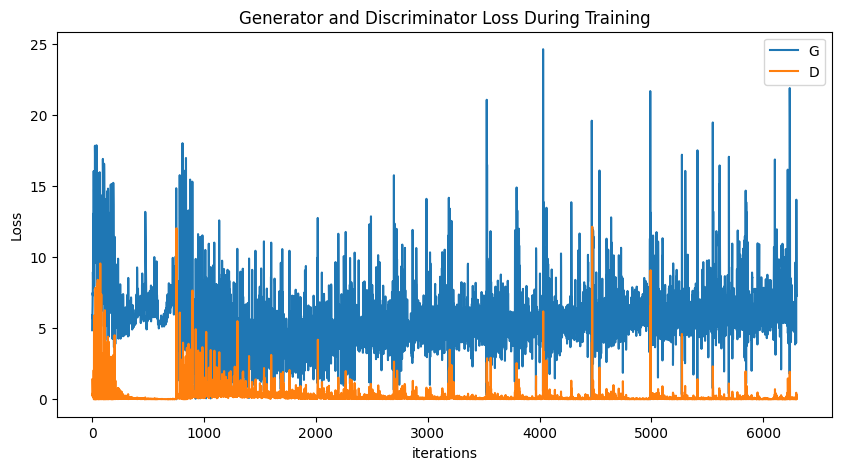

In [36]:
# Generator and Discriminator's loss graph
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(losses_G,label="G")
plt.plot(losses_D,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

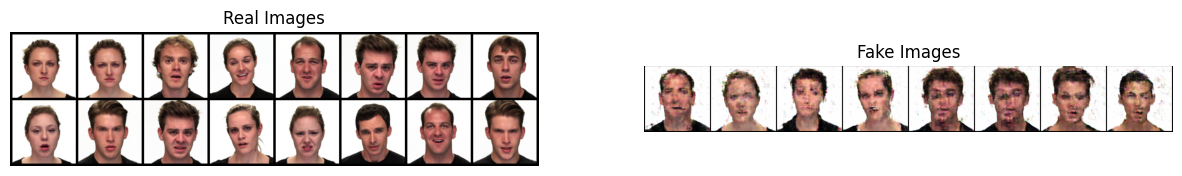

In [37]:
# selecting a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plotting the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plotting the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

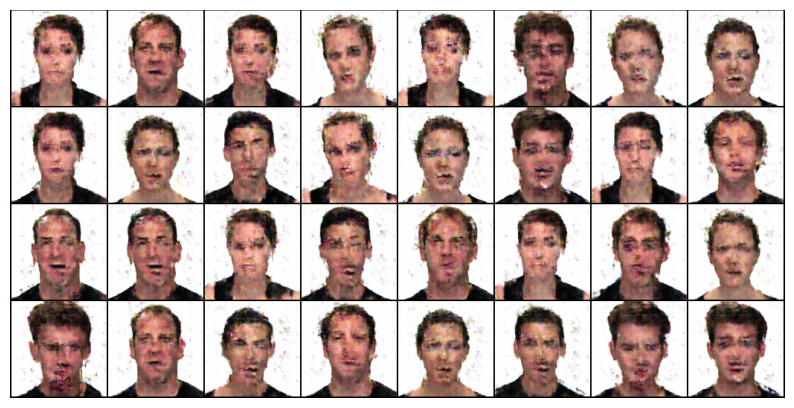

In [39]:
gNet.eval()
noise = torch.randn(32, 100, 1, 1, device=device)
with torch.no_grad():
    fake_image = gNet(noise).detach().cpu()

import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Converting tensors to image format
fake_image = fake_image.squeeze(0)  # Remove batch dimension
fake_image = vutils.make_grid(fake_image, normalize=True)

# Displaying the images
plt.figure(figsize=(10, 10))
plt.imshow(fake_image.permute(1, 2, 0))  # Rearranging the dimensions for matplotlib
plt.axis('off')
plt.show()
